# Data wrangling
Read, clean, simplify, and save data from  2 datasets: 
* Urban mining maps for PBL
* Road network of NL

In [1]:
import pandas as pd
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
pd.options.mode.chained_assignment = None  # default='warn'

## 1. Urban mining maps, from PBL
* to do: read and examine dataset - look out for availability of material supply (and demand?) for each location in NL 
* to do: pick suitable material flows, time frame

In [21]:
# read PBL data 
gdfs = []
for name in ['appartement', 'Detailhandel', 'Kantoor', 'losstaand', 'NijverheidEnLogistiek', 'Overheid_kw_diensten', 'rijtjeswoning']: 
    # read data
    readSupply = gpd.read_file('../_bigData/pblUrbanMiningModels/secondaryResourceSupply/WLO_hoog_DichtBij_Sloop_{}.shp'.format(name))
    supply = readSupply.copy()

    # formatting
    supply.rename(columns={
        'Id': 'id', 'bouwjaar': 'buildYear', 'GO': 'GFA',
        'Class': 'class', 'Staal': 'steel', 'Koper': 'copper', 'Aluminium': 'aluminium',
        'Hout': 'wood', 'Beton': 'concrete', 'Baksteen': 'brick', 'Glas': 'glass',
        'Keramiek': 'ceramic', 'Plastic': 'plastic', 'Isolatie': 'insulat', 
        'gebr_woonf': 'gebrWoonf', 'Overige_co': 'overig_c', 'Overig_met': 'overig_m', 'Overig': 'overig'
    }, inplace=True)
    supply = supply[[
        'id', 'gridcode', 'buildYear', 'GFA', 'gebrWoonf', 'class', 'steel',
        'copper', 'aluminium', 'wood', 'concrete', 'brick', 'glass', 'ceramic', 'plastic', 'insulat', 
        'overig_m', 'overig_c', 'overig', 'geometry'
    ]]
    
    # add to list
    gdfs.append(supply)

# combine all gdfs into one
supply = pd.concat(gdfs)
supply = gpd.GeoDataFrame(supply)
supply = supply.set_crs('EPSG:28992')
supply.geometry = supply.geometry.centroid

In [22]:
%%time
supply.to_file('data/secondaryMaterialSupply/supply_NL.shp')

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


CPU times: total: 13.5 s
Wall time: 13.5 s


## 2. Road network of the Netherlands, from OSM or other sources
* to do: test if spatial network analysis works (calculate travel time, shortest distance) with simplified map from geoFluxus. Try osmnx first, and if that fails, try other network analysis modules

In [36]:
%%time
place_name = 'amsterdam, north holland, netherlands'
highwayGraph = ox.graph_from_place(place_name, custom_filter='["highway"~"primary|secondary|tertiary"]') # use the pipe (|) as 'or' operator

C:\Users\tpytsui\Miniconda\envs\geo_env\lib\site-packages\osmnx\geocoder.py:110: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(_geocode_query_to_gdf(q, wr, by_osmid))


CPU times: total: 5.64 s
Wall time: 28.7 s


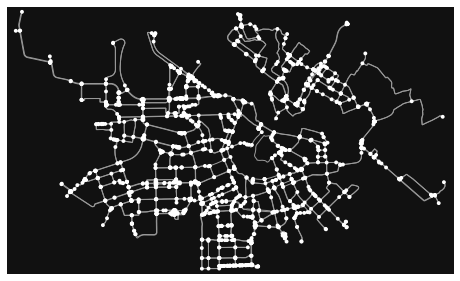

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [37]:
ox.plot_graph(highwayGraph)

In [38]:
# make gdf of nodes and edges
nodes, edges = ox.graph_to_gdfs(highwayGraph)

# edges: add max speed, travel time, change crs
edges.maxspeed = edges.maxspeed.map(lambda x: x[0] if isinstance(x, list) else x)
edges.maxspeed = edges.maxspeed.astype('float64')
edges.maxspeed = edges.maxspeed.fillna(50)
edges["time_s"] = edges['length'] / (edges.maxspeed / 3.6)
edges = edges.to_crs('EPSG:28992')

# nodes: change crs, fix xy
nodes = nodes.to_crs('EPSG:28992')
nodes.x, nodes.y = nodes.geometry.x, nodes.geometry.y

# essential step: update graph with new edges information: travel_time_seconds
G = ox.graph_from_gdfs(nodes, edges)

In [39]:
# edges - remove lists in columns in order to save shpfile
colsWithList = []
for col in edges.columns: 
    isList = edges[col].map(lambda x: isinstance(x, list))
    if isList.sum() >= 1: 
        colsWithList.append(col)
for col in colsWithList: 
    edges[col] = edges[col].map(lambda x: ', '.join([str(item) for item in x]) if isinstance(x, list) else str(x))

In [40]:
# save files 
nodes.to_file('data/roads/ams_nodes.shp')
edges.to_file('data/roads/ams_edges.shp')
ox.save_graphml(G, 'data/roads/ams_graph.graphml')

C:\Users\tpytsui\AppData\Local\Temp\ipykernel_4820\2493384889.py:2: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  nodes.to_file('data/roads/ams_nodes.shp')


# Visualisation

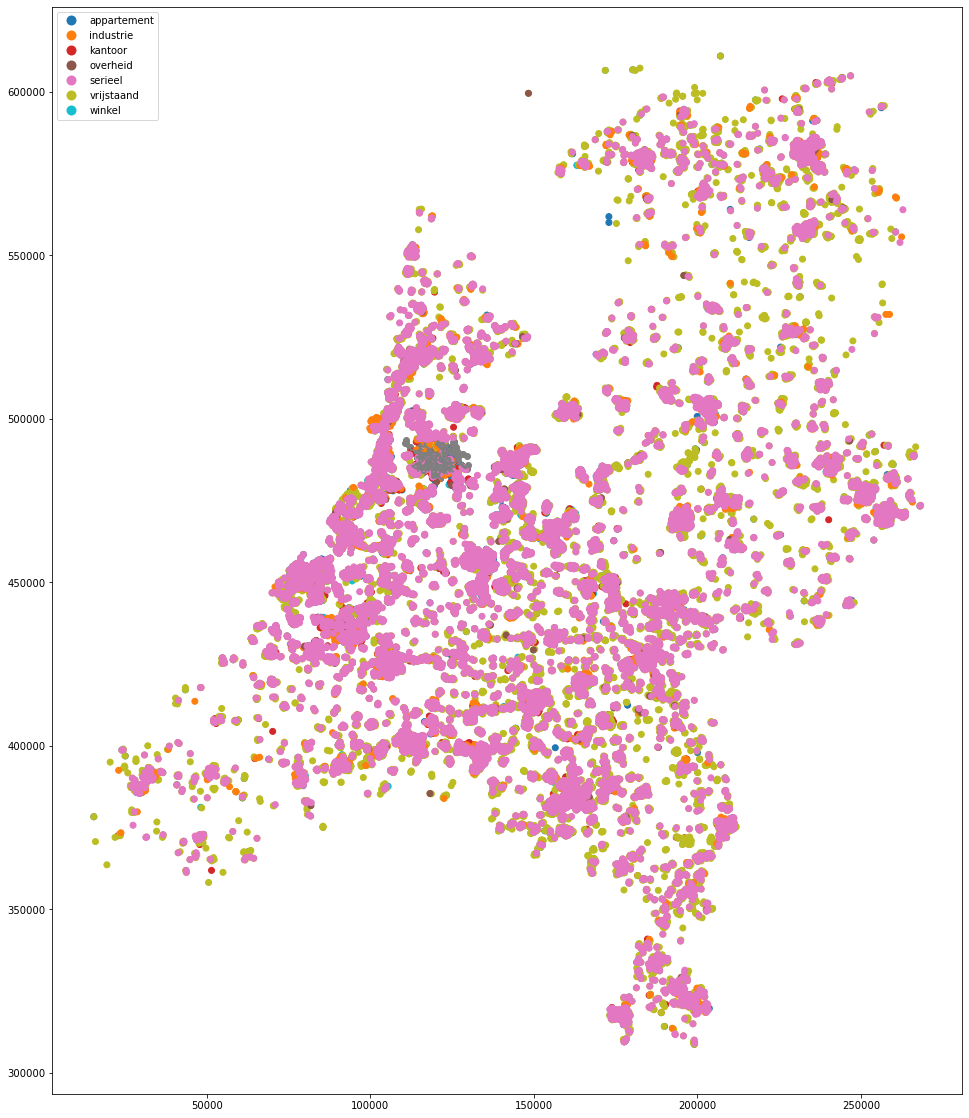

In [42]:
fig, ax = plt.subplots(1,1,figsize=(20,20))

edges.plot(ax=ax, color='grey')
nodes.plot(ax=ax, color='grey')
supply.plot(ax=ax, column='class', legend=True)

plt.show()